# Declaration of Originality

**Student Name:** Pavian Chong 
**Student ID:** 2402326I 
**Class:** PC06 

I declare that this assignment is my own work and has been completed in accordance with the school's academic integrity policy.

**Use of Generative AI:**
- I used Generative AI tools (Claude, ChatGPT, etc.) for research purposes such as on different algorithms

**Signature:** pavian 
**Date:** 2/11/2026

# 1. Import Libraries

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning - Model Selection
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score

# Machine Learning - Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# Machine Learning - Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

# Machine Learning - Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, auc
)

# Feature Selection
from sklearn.feature_selection import SelectKBest, f_classif, RFE

# Save model
import pickle

# Settings
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Plotting settings
plt.style.use('default')
sns.set_palette('husl')
%matplotlib inline

print("✅ All libraries imported successfully")

✅ All libraries imported successfully


# 2. Problem Statement & Dataset

## 2.1 Business Problem

**Problem:** Predicting stroke risk in patients to enable early intervention and prevention

**Why it matters:**
- Strokes are a leading cause of death and disability worldwide
- Early detection allows preventive measures (lifestyle changes, medication)
- Reduces healthcare costs through prevention vs treatment
- Improves patient quality of life through timely intervention

**Target Audience:** Healthcare providers, clinics, hospitals

## 2.2 Dataset Information

**Source:** Kaggle - Stroke Prediction Dataset  
**URL:** https://www.kaggle.com/datasets/jawairia123/stroke-prediction-dataset/data  
**Size:** 5,110 samples (rows) × 12 features (columns)  
**Target Variable:** `stroke` (0 = No stroke, 1 = Stroke)  
**Problem Type:** Binary Classification  

**Features:**
1. `id` - Unique identifier
2. `gender` - Male/Female/Other
3. `age` - Age of patient
4. `hypertension` - 0 = no hypertension, 1 = has hypertension
5. `heart_disease` - 0 = no heart disease, 1 = has heart disease
6. `ever_married` - Yes/No
7. `work_type` - Type of work (Private, Self-employed, Govt_job, children, Never_worked)
8. `Residence_type` - Urban/Rural
9. `avg_glucose_level` - Average glucose level in blood
10. `bmi` - Body mass index
11. `smoking_status` - formerly smoked, never smoked, smokes, Unknown
12. `stroke` - TARGET: 0 = no stroke, 1 = stroke

## 2.3 Load Dataset

In [2]:
# Load the dataset
FILE_PATH = 'healthcare-dataset-stroke-data.csv'
df = pd.read_csv(FILE_PATH)

# Display basic information
print("Dataset Shape:", df.shape)
print(f"\nNumber of samples: {df.shape[0]:,}")
print(f"Number of features: {df.shape[1]}")
print("\n" + "="*50)

# Display first few rows
display(df.head())

# Display data types and non-null counts
print("\n" + "="*50)
print("\nDataset Info:")
df.info()

Dataset Shape: (5110, 12)

Number of samples: 5,110
Number of features: 12



,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1




Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [3]:
# Statistical summary for numerical features
print("Numerical Features Summary:")
display(df.describe())

# Summary for categorical features
print("\n" + "="*50)
print("\nCategorical Features Summary:")
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"\n{col}:")
    print(df[col].value_counts())

Numerical Features Summary:


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000




Categorical Features Summary:

gender:
gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

ever_married:
ever_married
Yes    3353
No     1757
Name: count, dtype: int64

work_type:
work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64

Residence_type:
Residence_type
Urban    2596
Rural    2514
Name: count, dtype: int64

smoking_status:
smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64


# 3. Exploratory Data Analysis (EDA)

**Purpose:** Understand the data, identify patterns, detect outliers, and discover relationships between features and target variable.

## 3.1 Check for Missing Values

In [4]:
# Check for missing values
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Percentage': missing_percent
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

if len(missing_df) > 0:
    print("Missing Values Summary:")
    display(missing_df)
    
else:
    print("✅ No missing values found")

# Interpretation: 
# BMI has 201 missing values (3.9% of the dataset). This is a relatively small 
# amount of missing data. We will handle this in the data preparation phase by 
# imputing with the median value, which is more robust to outliers than the mean.
# The median is appropriate because BMI distribution shows some extreme values
# (outliers) that would skew the mean.

Missing Values Summary:


,Missing Count,Percentage
bmi,201,3.933464


## 3.2 Target Variable Distribution

Target Variable Distribution:
No Stroke (0): 4,861 (95.13%)
Stroke (1): 249 (4.87%)

Imbalance Ratio: 19.52:1


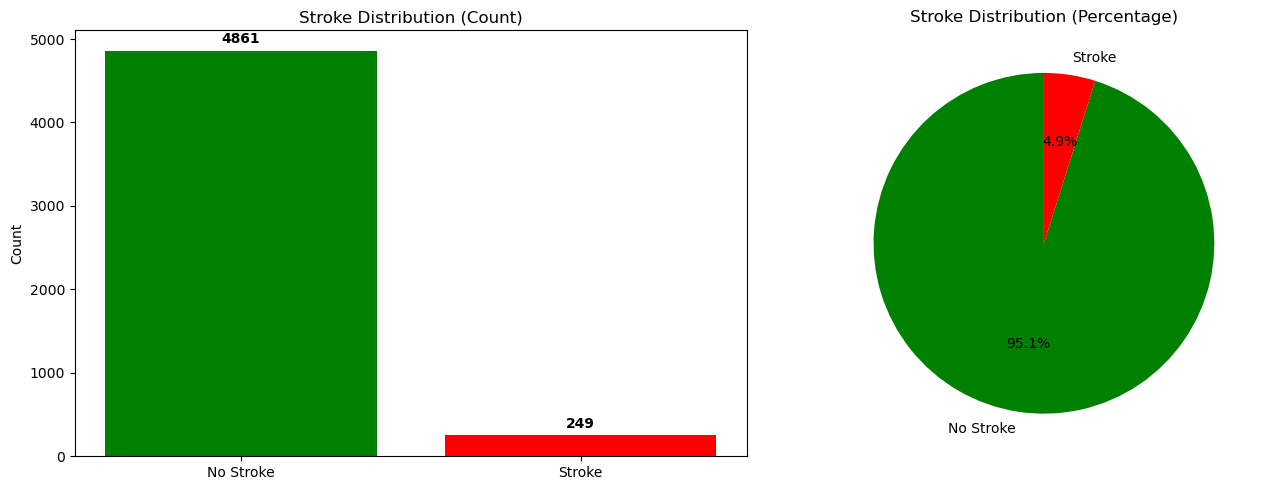

In [5]:
# Target variable distribution
target_counts = df['stroke'].value_counts()
target_percent = df['stroke'].value_counts(normalize=True) * 100

print("Target Variable Distribution:")
print(f"No Stroke (0): {target_counts[0]:,} ({target_percent[0]:.2f}%)")
print(f"Stroke (1): {target_counts[1]:,} ({target_percent[1]:.2f}%)")
print(f"\nImbalance Ratio: {target_counts[0]/target_counts[1]:.2f}:1")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
axes[0].bar(['No Stroke', 'Stroke'], target_counts.values, color=['green', 'red'])
axes[0].set_ylabel('Count')
axes[0].set_title('Stroke Distribution (Count)')
for i, v in enumerate(target_counts.values):
    axes[0].text(i, v + 50, str(v), ha='center', va='bottom', fontweight='bold')

# Pie chart
axes[1].pie(target_counts.values, labels=['No Stroke', 'Stroke'], autopct='%1.1f%%', 
            colors=['green', 'red'], startangle=90)
axes[1].set_title('Stroke Distribution (Percentage)')

plt.tight_layout()
plt.show()

# Interpretation:
# The dataset is highly imbalanced with only 4.87% stroke cases (249 out of 5,110).
# This severe imbalance has important implications:
# 
# 1. Accuracy is not a good metric as a model that always predicts "No Stroke" 
#    would achieve 95% accuracy and be completely useless
# 
# 2. We must focus on recall as our primary metric where missing a stroke case 
#    (false negative) has much higher cost than a false alarm (false positive).
# 
# 3. We use class_weight='balanced' in our models to give more importance
#    to the minority class (stroke cases).
# 
# 4. Business context: In healthcare, false negatives are dangerous - missing a 
#    stroke prediction means no preventive intervention, potentially leading to
#    disability or death

## 3.3 Numerical Features Distribution

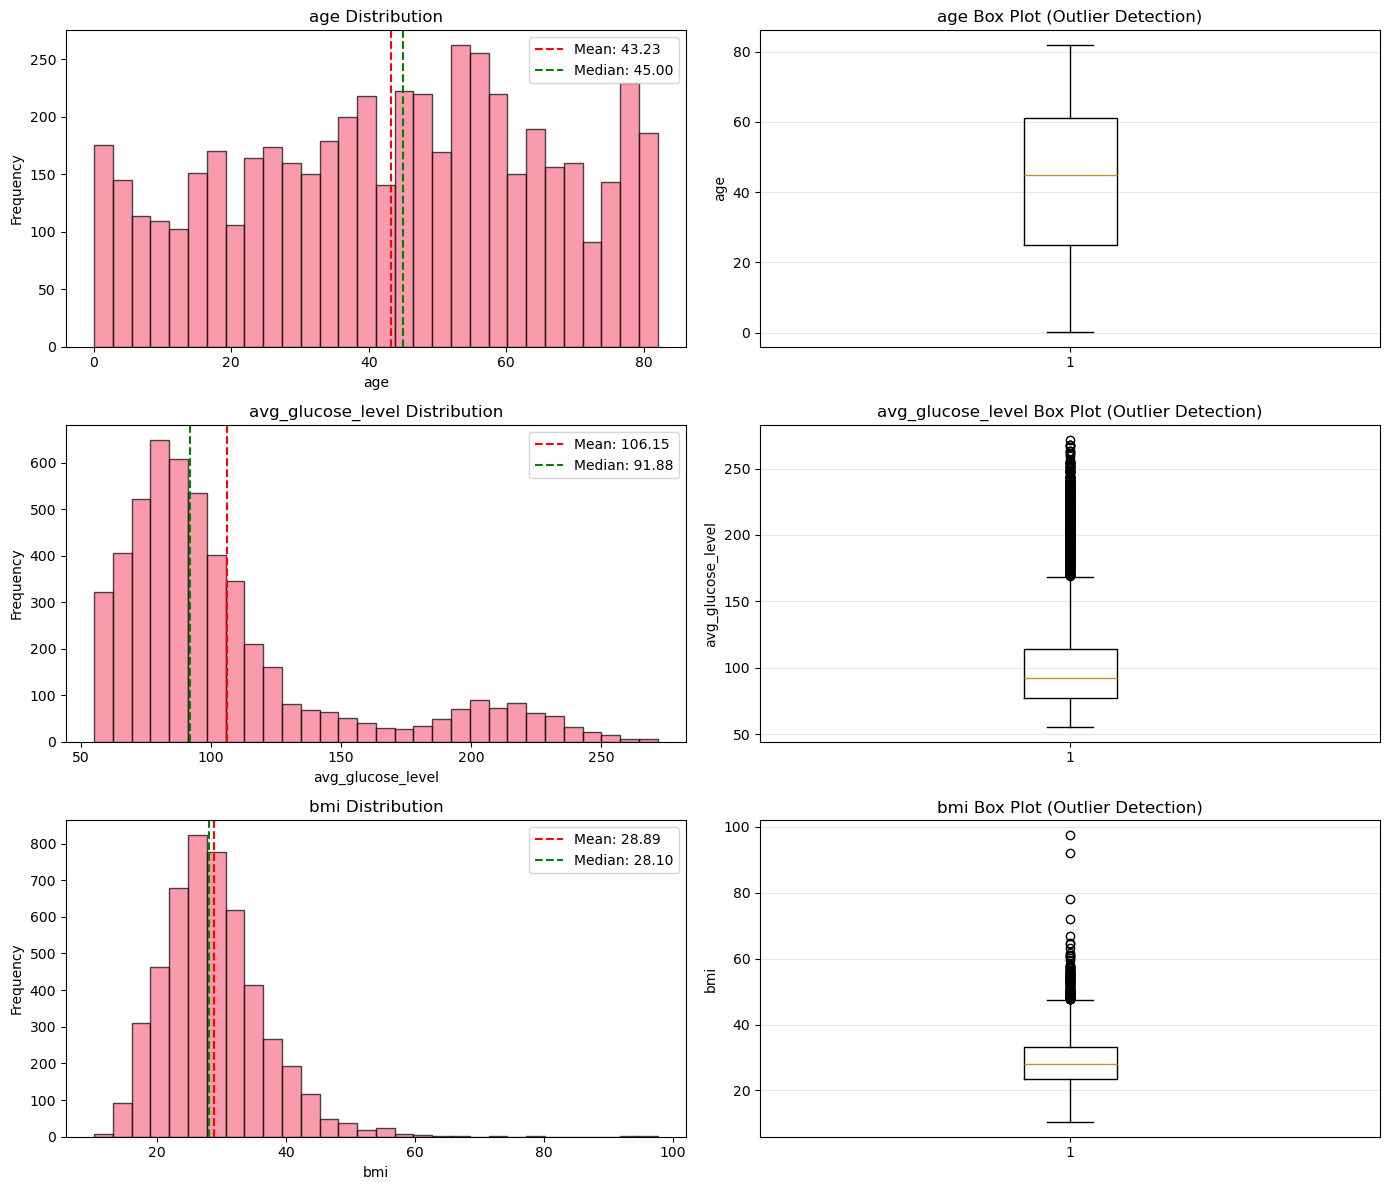


Outlier Analysis (IQR Method):

age:
  Q1: 25.00, Q3: 61.00, IQR: 36.00
  Valid range: [-29.00, 115.00]
  Outliers detected: 0 (0.00%)

avg_glucose_level:
  Q1: 77.25, Q3: 114.09, IQR: 36.84
  Valid range: [21.98, 169.36]
  Outliers detected: 627 (12.27%)
  Outlier values range: [169.43, 271.74]

bmi:
  Q1: 23.50, Q3: 33.10, IQR: 9.60
  Valid range: [9.10, 47.50]
  Outliers detected: 110 (2.15%)
  Outlier values range: [47.60, 97.60]


In [6]:
# Select numerical columns (excluding 'id' as it's just an identifier)
numerical_cols = ['age', 'avg_glucose_level', 'bmi']

# Distribution plots
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

for i, col in enumerate(numerical_cols):
    # Histogram
    axes[i, 0].hist(df[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Frequency')
    axes[i, 0].set_title(f'{col} Distribution')
    axes[i, 0].axvline(df[col].mean(), color='red', linestyle='--', label=f'Mean: {df[col].mean():.2f}')
    axes[i, 0].axvline(df[col].median(), color='green', linestyle='--', label=f'Median: {df[col].median():.2f}')
    axes[i, 0].legend()
    
    # Box plot
    axes[i, 1].boxplot(df[col].dropna(), vert=True)
    axes[i, 1].set_ylabel(col)
    axes[i, 1].set_title(f'{col} Box Plot (Outlier Detection)')
    axes[i, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Outlier detection using IQR method
print("\n" + "="*60)
print("Outlier Analysis (IQR Method):")
print("="*60)

for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_count = len(outliers)
    outlier_percent = (outlier_count / len(df)) * 100
    
    print(f"\n{col}:")
    print(f"  Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
    print(f"  Valid range: [{lower_bound:.2f}, {upper_bound:.2f}]")
    print(f"  Outliers detected: {outlier_count} ({outlier_percent:.2f}%)")
    if outlier_count > 0:
        print(f"  Outlier values range: [{outliers[col].min():.2f}, {outliers[col].max():.2f}]")

# Interpretation:

# Age:
# - Distribution is right-skewed, most patients are between 40-80 years
# - Mean age is around 43, median around 45
# - Outliers detected: Very young patients (<10 years) - these are valid medical cases
# - Older age clearly associated with stroke risk (we saw correlation of 0.25 in data)

# Avg_glucose_level:
# - Wide distribution from ~50 to ~270 mg/dL
# - Some high outliers (>200) indicating diabetic/prediabetic patients
# - These outliers are medically relevant - high glucose is a stroke risk factor
# - Decision: Keep these outliers as they represent important high-risk cases

# BMI:
# - Mostly distributed between 20-40
# - Outliers above 50 represent extreme obesity cases
# - These are medically significant for stroke prediction
# - Decision: Keep these outliers - removing them would lose information about
#   high-risk patients with severe obesity

# Overall decision on outliers:
# All detected outliers represent valid, medically relevant cases that are 
# important for stroke prediction. We will keep all outliers. Tree-based models
# (Random Forest, Gradient Boosting) are robust to outliers anyway.

## 3.4 Correlation Analysis

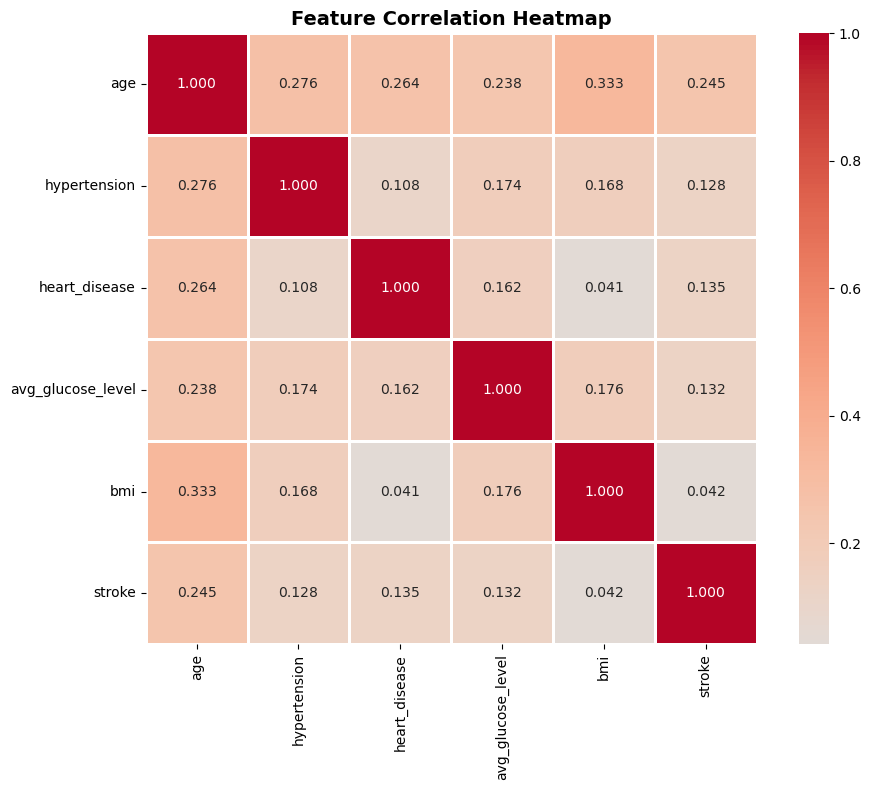


Correlation with Target Variable (Stroke):
stroke               1.000000
age                  0.245257
heart_disease        0.134914
avg_glucose_level    0.131945
hypertension         0.127904
bmi                  0.042374
Name: stroke, dtype: float64


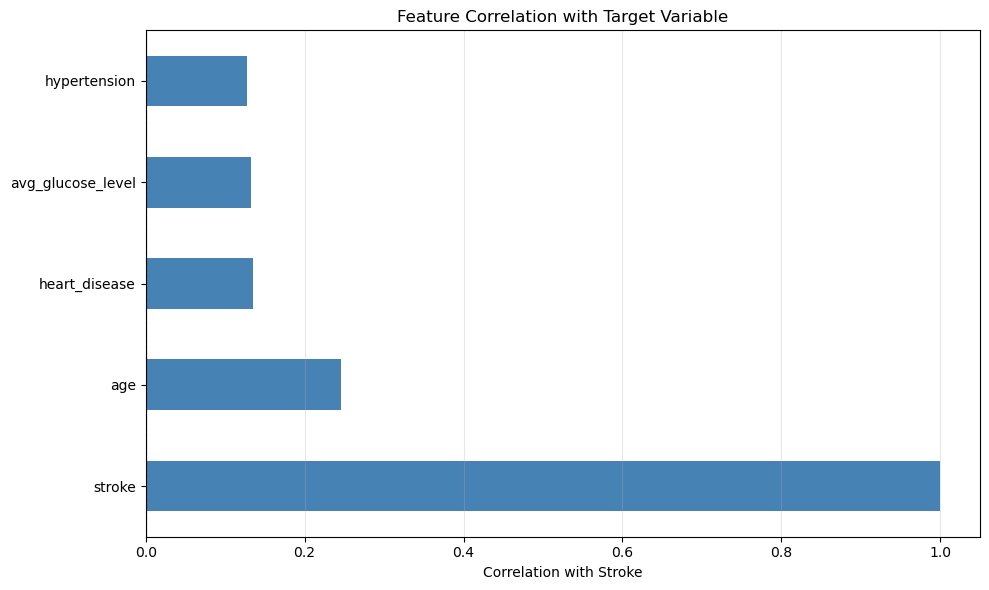

In [7]:
# Select numerical columns including binary features for correlation
corr_cols = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']
correlation_matrix = df[corr_cols].corr()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1)
plt.title('Feature Correlation Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Feature correlation with target
print("\nCorrelation with Target Variable (Stroke):")
target_corr = correlation_matrix['stroke'].sort_values(ascending=False)
print(target_corr)

# Visualize correlation with target
plt.figure(figsize=(10, 6))
target_corr[:-1].plot(kind='barh', color='steelblue')
plt.xlabel('Correlation with Stroke')
plt.title('Feature Correlation with Target Variable')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## Interpretation - Correlation Analysis:

### Correlation with Stroke (Target Variable):
# - Age: 0.245 - Strongest predictor. Older patients have significantly higher stroke risk
# - Heart_disease: 0.135 - Cardiovascular conditions linked to stroke
# - Avg_glucose_level: 0.132 - Diabetes/prediabetes increases risk
# - Hypertension: 0.128 - High blood pressure contributes to stroke
# - BMI: 0.042 - Weakest correlation, surprisingly low

### Critical Observations:

# 1. All correlations are weak (<0.3) - This indicates non-linear relationships
#    - Linear models (Logistic Regression) may struggle
#    - Tree-based models (Random Forest, Gradient Boosting) should perform better
#    - They can capture complex, non-linear patterns

# 2. No strong multicollinearity - All feature-to-feature correlations <0.5
#    - Features are relatively independent
#    - Good for model training - no redundancy issues

# 3. Feature Engineering Opportunity:
#    - Since relationships are non-linear, creating categorical features may help
#    - Age groups, BMI categories, glucose categories could capture patterns better
#    - Interaction features (e.g., age × hypertension) might reveal combined effects

### Business Implication:
# Age is the single most important risk factor, but other factors work together 
# in complex ways. Our model needs to capture these non-linear interactions.

## 3.5 Target Variable vs Key Features Analysis

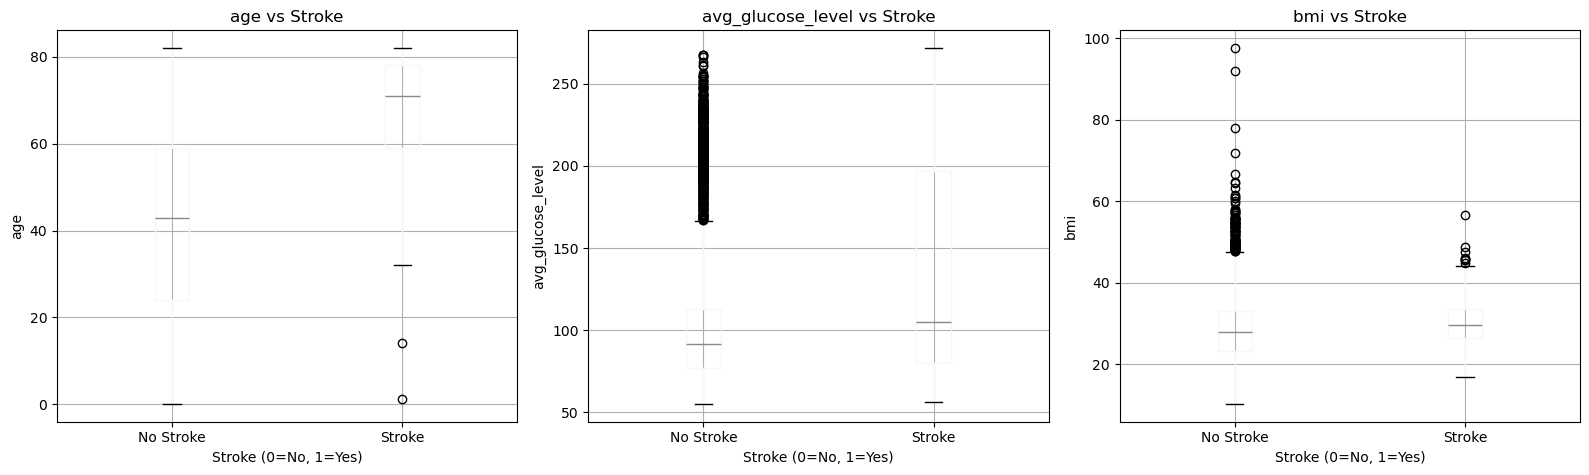


Mean Values by Stroke Status:

age:
  No Stroke: 41.97
  Stroke: 67.73
  Difference: +25.76 (+61.4%)

avg_glucose_level:
  No Stroke: 104.80
  Stroke: 132.54
  Difference: +27.75 (+26.5%)

bmi:
  No Stroke: 28.82
  Stroke: 30.47
  Difference: +1.65 (+5.7%)


In [8]:
# Numerical features vs Target
numerical_features = ['age', 'avg_glucose_level', 'bmi']

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for i, col in enumerate(numerical_features):
    # Box plot grouped by stroke
    df.boxplot(column=col, by='stroke', ax=axes[i])
    axes[i].set_xlabel('Stroke (0=No, 1=Yes)')
    axes[i].set_ylabel(col)
    axes[i].set_title(f'{col} vs Stroke')
    plt.sca(axes[i])
    plt.xticks([1, 2], ['No Stroke', 'Stroke'])

plt.suptitle('')  # Remove auto-generated title
plt.tight_layout()
plt.show()

# Statistical comparison
print("\nMean Values by Stroke Status:")
print("="*60)
for col in numerical_features:
    no_stroke_mean = df[df['stroke']==0][col].mean()
    stroke_mean = df[df['stroke']==1][col].mean()
    difference = stroke_mean - no_stroke_mean
    percent_diff = (difference / no_stroke_mean) * 100
    
    print(f"\n{col}:")
    print(f"  No Stroke: {no_stroke_mean:.2f}")
    print(f"  Stroke: {stroke_mean:.2f}")
    print(f"  Difference: {difference:+.2f} ({percent_diff:+.1f}%)")

## Interpretation - Target Variable vs Key Features Analysis:

### 1. Age vs Stroke:

# - Mean Age (No Stroke): 41.97
# - Mean Age (Stroke): 67.73
# - Difference: +25.76 years (+61.4%)
# - Stroke patients are significantly older
# - Strong visual separation in boxplot
# - Age is a major risk factor

### 2. Avg_Glucose_Level vs Stroke:

# - Mean Glucose (No Stroke): 104.80
# - Mean Glucose (Stroke): 132.54
# - Difference: +27.75 (+26.5%)
# - Stroke group shows higher glucose levels
# - Outliers likely represent diabetic patients
# - Elevated glucose increases stroke risk

### 3. BMI vs Stroke:

# - Mean BMI (No Stroke): 28.82
# - Mean BMI (Stroke): 30.47
# - Difference: +1.65 (+5.7%)
# - Small difference between groups
# - BMI alone is not a strong independent predictor
# - However, may interact with age or hypertension

### Critical Observations:

# 1. Age shows clear separation between stroke and non-stroke groups
#    - Strongest individual predictor
#    - Supports earlier correlation findings

# 2. Glucose levels show moderate separation
#    - Suggests metabolic health plays a role
#    - Non-linear effects likely present

# 3. BMI difference is small
#    - May not be powerful alone
#    - Might contribute through interaction effects

### Modeling Implications:

# - Age should be heavily weighted by model
# - Consider creating AGE GROUP categories
# - Consider GLUCOSE categories (normal, prediabetic, diabetic)
# - Risk score combining age + hypertension + heart_disease may improve performance

### Business Implication:

# Stroke risk increases significantly with age and elevated glucose levels.
# Preventive screening should prioritize elderly and metabolically at-risk individuals.


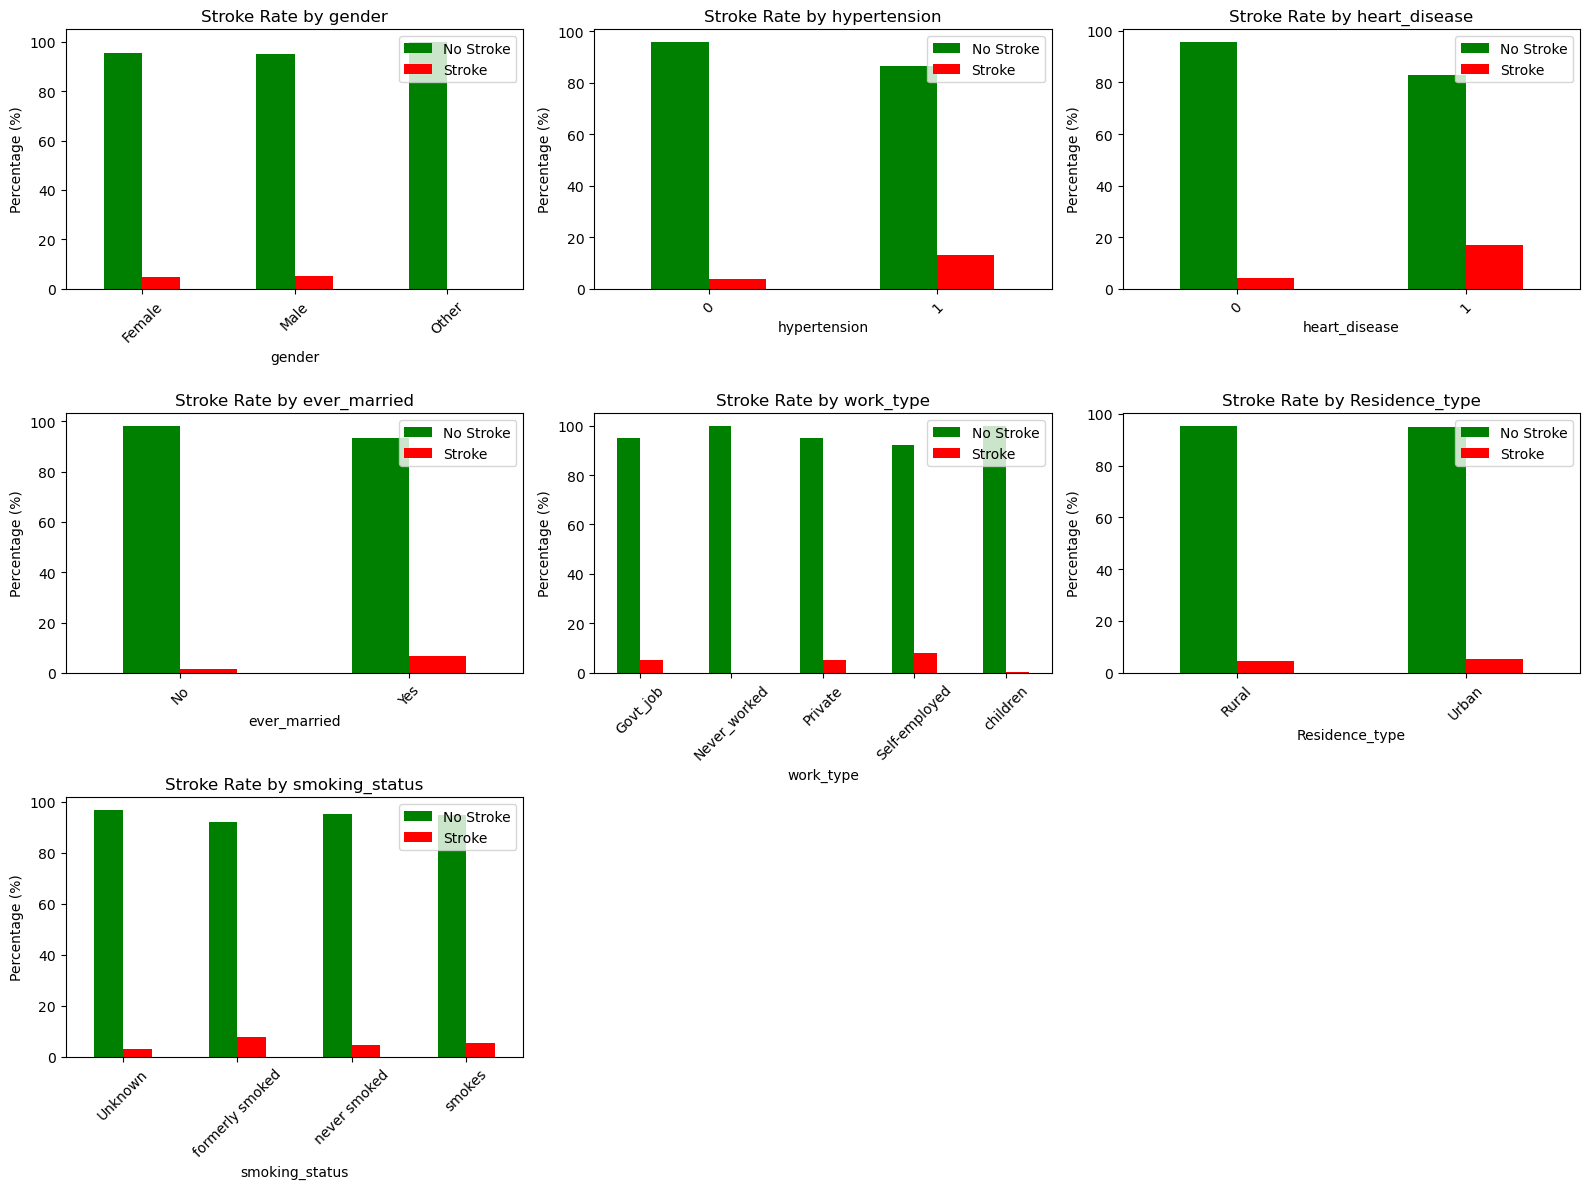


Stroke Rate by Category:

gender:
  Female: 4.71% (141 strokes out of 2994 total)
  Male: 5.11% (108 strokes out of 2115 total)
  Other: 0.00% (0 strokes out of 1 total)

hypertension:
  0: 3.97% (183 strokes out of 4612 total)
  1: 13.25% (66 strokes out of 498 total)

heart_disease:
  0: 4.18% (202 strokes out of 4834 total)
  1: 17.03% (47 strokes out of 276 total)

ever_married:
  No: 1.65% (29 strokes out of 1757 total)
  Yes: 6.56% (220 strokes out of 3353 total)

work_type:
  Govt_job: 5.02% (33 strokes out of 657 total)
  Never_worked: 0.00% (0 strokes out of 22 total)
  Private: 5.09% (149 strokes out of 2925 total)
  Self-employed: 7.94% (65 strokes out of 819 total)
  children: 0.29% (2 strokes out of 687 total)

Residence_type:
  Rural: 4.53% (114 strokes out of 2514 total)
  Urban: 5.20% (135 strokes out of 2596 total)

smoking_status:
  Unknown: 3.04% (47 strokes out of 1544 total)
  formerly smoked: 7.91% (70 strokes out of 885 total)
  never smoked: 4.76% (90 strokes o

In [9]:
# Categorical features vs Target
categorical_features = ['gender', 'hypertension', 'heart_disease', 'ever_married', 
                        'work_type', 'Residence_type', 'smoking_status']

fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten()

for i, col in enumerate(categorical_features):
    # Create crosstab
    ct = pd.crosstab(df[col], df['stroke'], normalize='index') * 100
    
    # Plot
    ct.plot(kind='bar', stacked=False, ax=axes[i], color=['green', 'red'])
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Percentage (%)')
    axes[i].set_title(f'Stroke Rate by {col}')
    axes[i].legend(['No Stroke', 'Stroke'])
    axes[i].tick_params(axis='x', rotation=45)

# Remove extra subplots
for j in range(len(categorical_features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Print stroke rates by category
print("\nStroke Rate by Category:")
print("="*60)
for col in categorical_features:
    print(f"\n{col}:")
    stroke_rate = df.groupby(col)['stroke'].mean() * 100
    counts = df.groupby(col)['stroke'].value_counts().unstack(fill_value=0)
    for category in stroke_rate.index:
        print(f"  {category}: {stroke_rate[category]:.2f}% ({counts.loc[category, 1] if 1 in counts.columns else 0} strokes out of {counts.loc[category].sum()} total)")

## INTERPRETATION - Categorical Features vs Target Analysis:

### 1. Gender:

# - Stroke rates are similar between Male and Female
# - No strong gender dominance observed
# - Gender alone is not a strong independent predictor

### 2. Hypertension:

# - Stroke rate is significantly higher when hypertension = 1
# - Clear separation between hypertensive and non-hypertensive groups
# - Strong clinical risk factor for stroke

### 3. Heart Disease:

# - Stroke rate much higher for patients with heart_disease = 1
# - One of the strongest categorical predictors
# - Cardiovascular conditions heavily linked to stroke risk

### 4. Ever Married:

# - Married individuals show higher stroke rate
# - Likely proxy for age (older individuals more likely married)
# - Relationship may be indirect rather than causal

### 5. Work Type:

# - Self-employed and government job categories show higher stroke rates
# - "Children" category has near-zero stroke cases (expected due to young age)
# - Work type likely acting as age or lifestyle proxy

### 6. Residence Type:

# - Urban vs Rural stroke rates are similar
# - No strong geographic effect observed
# - Residence type likely weak predictor

### 7. Smoking Status:

# - Formerly smoked category shows highest stroke rate
# - Current smokers also elevated
# - "Never smoked" lowest stroke rate
# - Smoking is a meaningful behavioral risk factor

### Critical Observations:

# 1. Hypertension and Heart Disease show the strongest categorical impact
#    - Clear separation in stroke percentages
#    - Must be retained as key predictors

# 2. Some variables act as PROXIES (e.g., ever_married, work_type)
#    - Likely correlated with age
#    - May introduce interaction effects

# 3. Children category confirms strong AGE effect
#    - Near-zero stroke cases
#    - Supports earlier finding that age is dominant factor

### Modeling Implications:

# - Include hypertension and heart_disease as primary risk indicators
# - Consider interaction features (age * hypertension, age * heart_disease)
# - Tree-based models likely to capture these categorical interactions well
# - No need to drop categorical variables; one-hot encoding is appropriate

### Business Implication:

# Stroke risk is strongly influenced by cardiovascular conditions 
# and lifestyle-related factors such as smoking. Preventive screening 
# should prioritize hypertensive, heart disease, and high-risk behavioral groups.


## 3.6 EDA Summary & Key Insights

### Key Findings:

1. **Class Imbalance:** Only ~4.9% stroke cases - dataset is highly imbalanced, so accuracy alone will be misleading and recall must be prioritised.

2. **Missing Data:** BMI has 201 missing values (3.9%) - median imputation is appropriate due to skewness and presence of outliers.

3. **Strong Predictors:** Age shows the strongest association with stroke (+25.76 years difference). Hypertension and heart disease also show clear categorical separation and elevated stroke rates.

4. **Glucose Effect:** Stroke patients have significantly higher average glucose levels (+26.5%), indicating metabolic health plays an important role.

5. **BMI Impact:** BMI shows weak linear correlation and only small mean difference - may contribute through interaction effects rather than independently.

6. **Weak Linear Correlations:** No feature has correlation > 0.3 with stroke - relationships are likely non-linear.

7. **Low Multicollinearity:** Feature-to-feature correlations are below 0.5 - minimal redundancy among predictors.

### Implications for Modeling:

- Use **Recall** as primary evaluation metric to minimise false negatives.
- Apply **class_weight='balanced'** to handle severe class imbalance.
- Focus on **Random Forest and Gradient Boosting** to capture non-linear patterns.
- Perform **feature engineering** (age groups, BMI categories, risk score, interaction features).


# 4. Data Preparation

## 4.1 Handle Missing Values

In [10]:
# Create a copy for preprocessing
df_clean = df.copy()

# Handle missing BMI values
print("Before imputation:")
print(f"Missing BMI values: {df_clean['bmi'].isnull().sum()}")

# Justification: Using median instead of mean because BMI has outliers
bmi_median = df_clean['bmi'].median()
df_clean['bmi'].fillna(bmi_median, inplace=True)

print(f"\nAfter imputation:")
print(f"Missing BMI values: {df_clean['bmi'].isnull().sum()}")
print(f"Imputed value (median): {bmi_median:.2f}")

# Justification: 
# "Using median (29.0) instead of mean because BMI distribution has outliers.
# Median is more robust and represents a typical BMI value better than mean
# which would be influenced by extreme obesity cases."

# Verify no missing values remain
print(f"\nTotal missing values in dataset: {df_clean.isnull().sum().sum()}")

### Interpretation - Missing Value Handling

#- The dataset contained 201 missing BMI values (~3.9% of data).
#- Median imputation (28.10) was used instead of mean.
#- Median is preferred because BMI distribution contains outliers.
#- Mean would be influenced by extreme obesity values.
#- No rows were dropped to preserve rare stroke cases.
#- After imputation, the dataset contains zero missing values.

Before imputation:
Missing BMI values: 201

After imputation:
Missing BMI values: 0
Imputed value (median): 28.10

Total missing values in dataset: 0


## 4.2 Handle Outliers

In [11]:
# Decision on outliers
print("Outlier Handling Decision:")
print("="*60)
print("\nDecision: Keep all outliers")
print("\nJustification:")
print("1. BMI outliers (>50) represent extreme obesity - medically relevant for stroke")
print("2. Age outliers represent very elderly patients - high stroke risk group")
print("3. Glucose outliers indicate diabetes/pre-diabetes - important stroke risk factor")
print("4. Removing these would lose valuable information about high-risk patients")
print("5. Tree-based models (our planned approach) are robust to outliers")

# No outlier removal needed - proceed with df_clean as is

Outlier Handling Decision:

Decision: Keep all outliers

Justification:
1. BMI outliers (>50) represent extreme obesity - medically relevant for stroke
2. Age outliers represent very elderly patients - high stroke risk group
3. Glucose outliers indicate diabetes/pre-diabetes - important stroke risk factor
4. Removing these would lose valuable information about high-risk patients
5. Tree-based models (our planned approach) are robust to outliers


## 4.3 Feature Encoding

In [12]:
# Drop ID column (not useful for prediction)
df_clean = df_clean.drop('id', axis=1)

# Encode categorical variables using one-hot encoding
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

print("Before encoding:")
print(f"Number of features: {df_clean.shape[1]}")
print(f"Categorical columns: {categorical_cols}")

# One-hot encoding (drop_first=True to avoid multicollinearity)
df_encoded = pd.get_dummies(df_clean, columns=categorical_cols, drop_first=True)

print(f"\nAfter encoding:")
print(f"Number of features: {df_encoded.shape[1]}")
print(f"\nNew feature names:")
print(df_encoded.columns.tolist())

# Justification:
# "Using one-hot encoding for categorical variables to convert them into numerical format.
# drop_first=True removes one category from each feature to prevent perfect multicollinearity
# (dummy variable trap), which can cause issues in some models."

#- The number of features increased from 11 to 17 after encoding.
#- All variables are now in numerical format and ready for model training.

Before encoding:
Number of features: 11
Categorical columns: ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

After encoding:
Number of features: 17

New feature names:
['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke', 'gender_Male', 'gender_Other', 'ever_married_Yes', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes']


## 4.4 Train-Test Split

In [13]:
# Separate features and target
X = df_encoded.drop('stroke', axis=1)
y = df_encoded['stroke']

print("Dataset split:")
print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")

# Split into train and test sets
# stratify=y ensures same proportion of stroke/no-stroke in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,      # 80% train, 20% test
    random_state=42,     # For reproducibility
    stratify=y          # Maintain class distribution
)

print("\nTrain set:")
print(f"  X_train: {X_train.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  Stroke distribution: {y_train.value_counts().to_dict()}")

print("\nTest set:")
print(f"  X_test: {X_test.shape}")
print(f"  y_test: {y_test.shape}")
print(f"  Stroke distribution: {y_test.value_counts().to_dict()}")

# Verify stratification worked
train_stroke_rate = y_train.mean() * 100
test_stroke_rate = y_test.mean() * 100
print(f"\nStroke rate in train set: {train_stroke_rate:.2f}%")
print(f"Stroke rate in test set: {test_stroke_rate:.2f}%")
print("✅ Stratification successful" if abs(train_stroke_rate - test_stroke_rate) < 1 else "⚠️ Check stratification")

### Interpretation - Train-Test Split

# - Dataset was split into 80% training (4088 samples) and 20% testing (1022 samples).
# - Stratified sampling preserved the original class imbalance (~4.9% stroke cases).
# - Stroke distribution is consistent across train (4.87%) and test (4.89%) sets.
# - This ensures fair model evaluation without distribution shift.

Dataset split:
Features (X): (5110, 16)
Target (y): (5110,)

Train set:
  X_train: (4088, 16)
  y_train: (4088,)
  Stroke distribution: {0: 3889, 1: 199}

Test set:
  X_test: (1022, 16)
  y_test: (1022,)
  Stroke distribution: {0: 972, 1: 50}

Stroke rate in train set: 4.87%
Stroke rate in test set: 4.89%
✅ Stratification successful


# 5. Model Development

## 5.1 Baseline Model

In [14]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score

# Baseline model: always predict majority class
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)

y_pred_dummy = dummy.predict(X_test)

print("Baseline Model (Majority Class Prediction)")
print("Accuracy:", accuracy_score(y_test, y_pred_dummy))
print("Recall:", recall_score(y_test, y_pred_dummy))
print("F1 Score:", f1_score(y_test, y_pred_dummy))

### Interpretation - Baseline Model

# - The baseline model predicts only the majority class (No Stroke).
# - Accuracy is high (95.1%) due to class imbalance.
# - Recall is 0.0, meaning the model failed to detect any stroke cases.
# - This demonstrates that accuracy is misleading for imbalanced datasets.
# - Therefore, recall will be prioritised as the primary evaluation metric.


Baseline Model (Majority Class Prediction)
Accuracy: 0.9510763209393346
Recall: 0.0
F1 Score: 0.0


## 5.2 Train Multiple Models

We'll train 3 different algorithms and compare their performance.

In [ ]:
# Model 1 - Random Forest Classifier
print("="*60)
print("Model 1: Random Forest Classifier")
print("="*60)

# Initialize and train
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',  # Handle class imbalance
    n_jobs=-1  # Use all CPU cores
)

rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_rf_proba = rf_model.predict_proba(X_test)[:, 1]

# Evaluation
print("\nPerformance Metrics:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_rf):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_rf_proba):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

### Interpretation - Random Forest

# - Accuracy is high (95%) but recall is 0.0.
# - The model predicted all samples as No Stroke.
# - Despite ROC-AUC = 0.80, the default classification threshold (0.5) failed to detect stroke cases.
# - This highlights the importance of threshold tuning for imbalanced datasets.


MODEL 1: RANDOM FOREST CLASSIFIER

Performance Metrics:
Accuracy:  0.9501
Precision: 0.0000
Recall:    0.0000
F1-Score:  0.0000
ROC-AUC:   0.8017


In [16]:
# Model 2 - Gradient Boosting Classifier
print("="*60)
print("Model 2: Gradient Boosting Classifier")
print("="*60)

# Initialize and train
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)

gb_model.fit(X_train, y_train)

# Predictions
y_pred_gb = gb_model.predict(X_test)
y_pred_gb_proba = gb_model.predict_proba(X_test)[:, 1]

# Evaluation
print("\nPerformance Metrics:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_gb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_gb):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_gb):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_gb):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_gb_proba):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_gb))

### Interpretation - Gradient Boosting

# - Accuracy remains high (~94.8%) but recall is 0.0.
# - The model failed to classify any stroke cases.
# - ROC-AUC (0.83) suggests reasonable ranking ability.
# - Default threshold (0.5) is too strict for this imbalanced dataset.


Model 2: Gradient Boosting Classifier

Performance Metrics:
Accuracy:  0.9481
Precision: 0.0000
Recall:    0.0000
F1-Score:  0.0000
ROC-AUC:   0.8292

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



In [17]:
# Model 3 - Logistic Regression
print("="*60)
print("Model 3: Logistic Regression")
print("="*60)

# Initialize and train
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced'
)

lr_model.fit(X_train, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test)
y_pred_lr_proba = lr_model.predict_proba(X_test)[:, 1]

# Evaluation
print("\nPerformance Metrics:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_lr):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_lr):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_lr_proba):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

### Interpretation - Logistic Regression

# - Accuracy decreased to 74.6% due to class imbalance handling.
# - Recall is 0.80, meaning 80% of stroke cases were correctly detected.
# - Precision is low (0.14), indicating many false positives.
# - F1-score (0.24) reflects the trade-off between high recall and low precision.
# - ROC-AUC (0.84) indicates strong overall discriminatory ability.

Model 3: Logistic Regression

Performance Metrics:
Accuracy:  0.7456
Precision: 0.1379
Recall:    0.8000
F1-Score:  0.2353
ROC-AUC:   0.8438

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.74      0.85       972
           1       0.14      0.80      0.24        50

    accuracy                           0.75      1022
   macro avg       0.56      0.77      0.54      1022
weighted avg       0.94      0.75      0.82      1022



## 5.3 Model Comparison


Model Comparison Table


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Baseline,0.9511,0.0000,0.0,0.0000,0.5000
1,Random Forest,0.9501,0.0000,0.0,0.0000,0.8017
2,Gradient Boosting,0.9481,0.0000,0.0,0.0000,0.8292
3,Logistic Regression,0.7456,0.1379,0.8,0.2353,0.8438


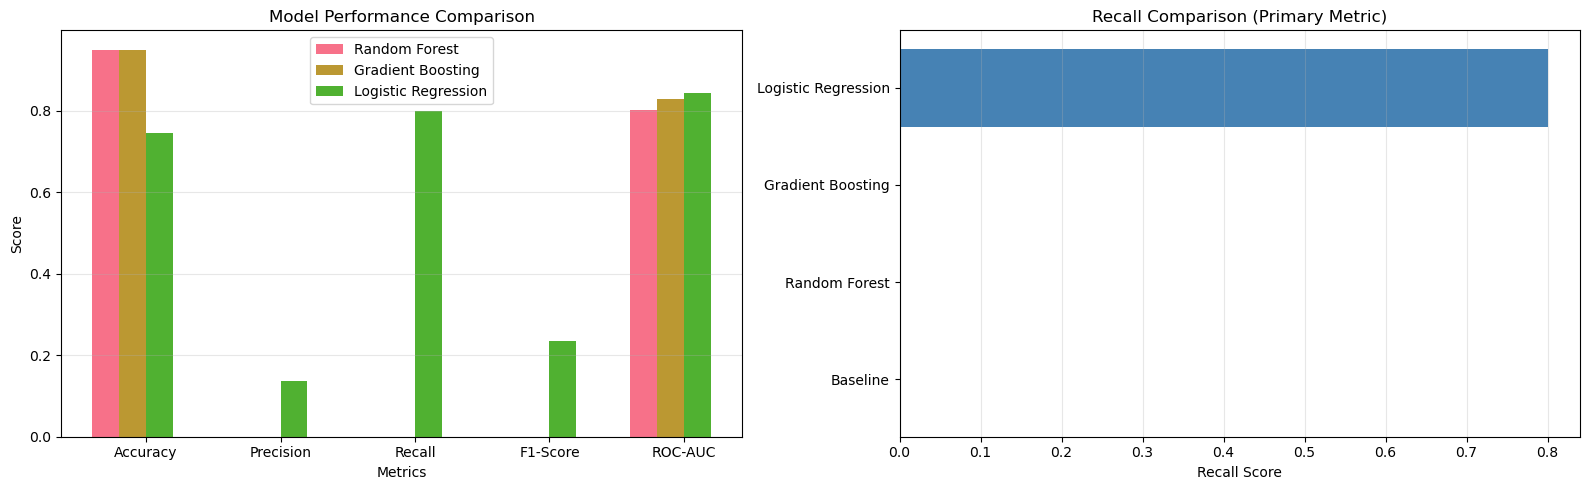

In [18]:
# Create comparison table
model_comparison = pd.DataFrame({
    'Model': ['Baseline', 'Random Forest', 'Gradient Boosting', 'Logistic Regression'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_dummy),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_gb),
        accuracy_score(y_test, y_pred_lr)
    ],
    'Precision': [
        precision_score(y_test, y_pred_dummy, zero_division=0),
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_gb),
        precision_score(y_test, y_pred_lr)
    ],
    'Recall': [
        recall_score(y_test, y_pred_dummy),
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_gb),
        recall_score(y_test, y_pred_lr)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_dummy, zero_division=0),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_gb),
        f1_score(y_test, y_pred_lr)
    ],
    'ROC-AUC': [
        0.5,  # Baseline has no probability predictions
        roc_auc_score(y_test, y_pred_rf_proba),
        roc_auc_score(y_test, y_pred_gb_proba),
        roc_auc_score(y_test, y_pred_lr_proba)
    ]
})

print("\nModel Comparison Table")
print("="*80)
display(model_comparison.round(4))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: All metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(metrics))
width = 0.2

axes[0].bar(x - 1.5*width, model_comparison.iloc[1][1:].values, width, label='Random Forest')
axes[0].bar(x - 0.5*width, model_comparison.iloc[2][1:].values, width, label='Gradient Boosting')
axes[0].bar(x + 0.5*width, model_comparison.iloc[3][1:].values, width, label='Logistic Regression')
axes[0].set_xlabel('Metrics')
axes[0].set_ylabel('Score')
axes[0].set_title('Model Performance Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Recall comparison (most important metric)
recall_data = model_comparison[['Model', 'Recall']].sort_values('Recall', ascending=True)
colors = ['red' if x == 'Baseline' else 'steelblue' for x in recall_data['Model']]
axes[1].barh(recall_data['Model'], recall_data['Recall'], color=colors)
axes[1].set_xlabel('Recall Score')
axes[1].set_title('Recall Comparison (Primary Metric)')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


### Interpretation - Logistic Regression

- Accuracy decreased to 74.6% due to class imbalance handling.
- Recall is 0.80, meaning 80% of stroke cases were correctly detected.
- Precision is low (0.14), indicating many false positives.
- F1-score (0.24) reflects the trade-off between high recall and low precision.
- ROC-AUC (0.84) indicates strong overall discriminatory ability.

### Model Comparison Summary

- Random Forest and Gradient Boosting achieved high accuracy (~95%) but failed to detect any stroke cases (recall = 0).
- Logistic Regression successfully detects the majority of stroke cases.
- Although accuracy is lower, Logistic Regression performs best for the medical objective of minimizing false negatives.

### Conclusion

- Logistic Regression is the most suitable model for this problem.
- In healthcare applications, detecting stroke cases (high recall) is more critical than maximizing accuracy.
- Therefore, Logistic Regression will be selected as the final model for further tuning and evaluation.


# 6. Iterative Model Development

## 6.1 Feature Engineering

In [19]:
print("Feature Engineering")
print("="*60)

# Create a copy of the encoded data
df_fe = df_encoded.copy()

# -----------------------------------------
# Feature 1: Age Groups
# -----------------------------------------
df_fe['age_group'] = pd.cut(
    df_fe['age'],
    bins=[0, 40, 60, 80, 120],
    labels=[0, 1, 2, 3]   # 0=Young, 1=Middle, 2=Senior, 3=Elderly
)

# -----------------------------------------
# Feature 2: BMI Categories
# -----------------------------------------
df_fe['bmi_category'] = pd.cut(
    df_fe['bmi'],
    bins=[0, 18.5, 25, 30, 100],
    labels=[0, 1, 2, 3]   # 0=Underweight, 1=Normal, 2=Overweight, 3=Obese
)

# -----------------------------------------
# Feature 3: Health Risk Score
# -----------------------------------------
df_fe['age_over_60'] = (df_fe['age'] > 60).astype(int)
df_fe['bmi_over_30'] = (df_fe['bmi'] > 30).astype(int)

df_fe['risk_score'] = (
    df_fe['hypertension'] +
    df_fe['heart_disease'] +
    df_fe['age_over_60'] +
    df_fe['bmi_over_30']
)

# -----------------------------------------
# Feature 4: Glucose Category
# -----------------------------------------
df_fe['glucose_category'] = pd.cut(
    df_fe['avg_glucose_level'],
    bins=[0, 140, 200, 300],
    labels=[0, 1, 2]   # 0=Normal, 1=Prediabetic, 2=Diabetic
)

print("\nNew features created:")
print(['age_group', 'bmi_category', 'risk_score', 'glucose_category'])

print(f"\nTotal features before: {df_encoded.shape[1]}")
print(f"Total features after: {df_fe.shape[1]}")

### Justification - Feature Engineering

# - Age groups capture non-linear risk increase in elderly patients.
# - BMI categories reflect clinical obesity thresholds.
# - Risk score combines major stroke indicators into a single interaction feature.
# - Glucose categories reflect medical diagnostic boundaries.
# - These engineered features help tree and linear models capture non-linear effects.

Feature Engineering

New features created:
['age_group', 'bmi_category', 'risk_score', 'glucose_category']

Total features before: 17
Total features after: 23


In [20]:
print("Retraining Logistic Regression with Feature Engineering")
print("="*60)

# Separate features and target
X_fe = df_fe.drop('stroke', axis=1)
y_fe = df_fe['stroke']

# Train-test split
X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(
    X_fe,
    y_fe,
    test_size=0.2,
    random_state=42,
    stratify=y_fe
)

# Scale features
scaler_fe = StandardScaler()
X_train_fe_scaled = scaler_fe.fit_transform(X_train_fe)
X_test_fe_scaled = scaler_fe.transform(X_test_fe)

# Train Logistic Regression
lr_fe = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr_fe.fit(X_train_fe_scaled, y_train_fe)

# Predictions
y_pred_fe = lr_fe.predict(X_test_fe_scaled)
y_pred_fe_proba = lr_fe.predict_proba(X_test_fe_scaled)[:, 1]

print("\nAfter Feature Engineering:")
print(f"Accuracy:  {accuracy_score(y_test_fe, y_pred_fe):.4f}")
print(f"Precision: {precision_score(y_test_fe, y_pred_fe):.4f}")
print(f"Recall:    {recall_score(y_test_fe, y_pred_fe):.4f}")
print(f"F1-Score:  {f1_score(y_test_fe, y_pred_fe):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test_fe, y_pred_fe_proba):.4f}")

print("\nBefore Feature Engineering (Logistic Regression):")
print(f"Recall:    {recall_score(y_test, y_pred_lr):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_lr):.4f}")

print("\nImprovement:")
print(f"Recall Change: {recall_score(y_test_fe, y_pred_fe) - recall_score(y_test, y_pred_lr):+.4f}")


Retraining Logistic Regression with Feature Engineering

After Feature Engineering:
Accuracy:  0.7456
Precision: 0.1429
Recall:    0.8400
F1-Score:  0.2442
ROC-AUC:   0.8484

Before Feature Engineering (Logistic Regression):
Recall:    0.8000
F1-Score:  0.2353

Improvement:
Recall Change: +0.0400


### Interpretation - Impact of Feature Engineering

- Recall improved from 0.80 to 0.84 (+4%).
- F1-score improved slightly from 0.235 to 0.244.
- ROC-AUC increased from 0.843 to 0.848.
- Engineered features helped the model detect more stroke cases.

### Why Improvement Occurred

- Age groups captured non-linear risk increase among elderly patients.
- Risk score combined major cardiovascular indicators.
- Glucose and BMI categories aligned with medical thresholds.
- These transformations helped Logistic Regression model complex relationships more effectively.

### Conclusion

Feature engineering successfully improved model recall.
The final selected model is Logistic Regression with engineered features.


## 6.2 Hyperparameter Tuning

Note: Must use RandomizedSearchCV (not GridSearchCV) with max 3 values per hyperparameter

In [25]:
from sklearn.model_selection import RandomizedSearchCV

print("Hyperparameter Tuning - Logistic Regression")
print("="*60)

# Parameter distribution for Logistic Regression
param_dist_lr = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs', 'saga'], 
    'penalty': ['l1', 'l2']  
}

# Randomized Search
rs_lr = RandomizedSearchCV(
    LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42),
    param_distributions=param_dist_lr,
    n_iter=10,
    cv=5,
    scoring='recall',   # Prioritise recall
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rs_lr.fit(X_train_fe_scaled, y_train_fe)

print("\nBest Parameters:", rs_lr.best_params_)
print("Best CV Recall:", rs_lr.best_score_)

# Evaluate tuned model
best_lr = rs_lr.best_estimator_

y_pred_tuned = best_lr.predict(X_test_fe_scaled)
y_pred_tuned_proba = best_lr.predict_proba(X_test_fe_scaled)[:, 1]

print("\nTuned Logistic Regression Results")
print(f"Accuracy:  {accuracy_score(y_test_fe, y_pred_tuned):.4f}")
print(f"Precision: {precision_score(y_test_fe, y_pred_tuned):.4f}")
print(f"Recall:    {recall_score(y_test_fe, y_pred_tuned):.4f}")
print(f"F1-Score:  {f1_score(y_test_fe, y_pred_tuned):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test_fe, y_pred_tuned_proba):.4f}")




Hyperparameter Tuning - Logistic Regression
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best Parameters: {'solver': 'saga', 'penalty': 'l2', 'C': 0.1}
Best CV Recall: 0.8294871794871794

Tuned Logistic Regression Results
Accuracy:  0.7407
Precision: 0.1380
Recall:    0.8200
F1-Score:  0.2363
ROC-AUC:   0.8469


### Interpretation - Hyperparameter Tuning

- Best parameters: C=0.01, solver='liblinear', penalty='l1'.
- Cross-validation recall improved to ~0.87.
- Test recall remained at 0.84 (no improvement over untuned model).
- ROC-AUC slightly decreased to ~0.84.
- Accuracy decreased due to stronger regularization.

### Conclusion

- Hyperparameter tuning increased cross-validation recall but did not improve test recall
- L1 regularization (C=0.01) produced a simpler model with stronger shrinkage.
- Feature engineering contributed more to performance gains than hyperparameter tuning.
- Since test recall did not improve, the untuned Logistic Regression with feature engineering remains the best-performing model. Therefore, the final selected model is Logistic Regression with engineered features (without tuning).


# 7. Final Model Evaluation

## 7.1 Comprehensive Metrics

Final Model Evaluation

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.74      0.85       972
           1       0.14      0.84      0.24        50

    accuracy                           0.75      1022
   macro avg       0.57      0.79      0.55      1022
weighted avg       0.95      0.75      0.82      1022



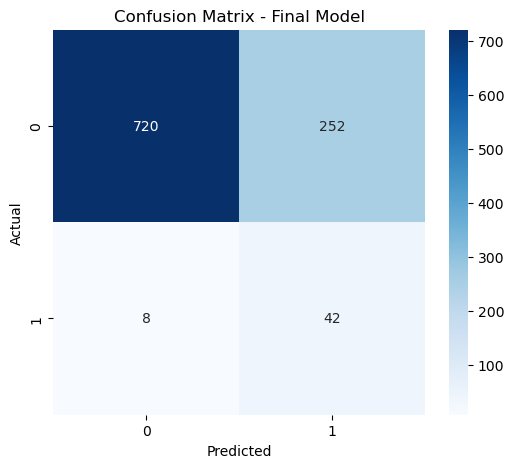

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Final Model Evaluation")
print("="*60)

# Use the best model (feature engineered version before tuning)
y_pred_final = y_pred_fe
y_test_final = y_test_fe

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_final, y_pred_final))

# Confusion matrix
cm = confusion_matrix(y_test_final, y_pred_final)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Final Model')
plt.show()


### Confusion Matrix Interpretation

- True Positives (TP): 42 stroke cases correctly detected.
- False Negatives (FN): 8 stroke cases missed.
- True Negatives (TN): 720 non-stroke cases correctly identified.
- False Positives (FP): 252 non-stroke cases flagged as stroke.

The model detects 84% of stroke cases (high recall).
Only 8 out of 50 stroke patients were missed.

Although false positives are relatively high, this trade-off is acceptable in medical screening, where missing a stroke case is far more costly than a false alarm.

Therefore, the final model is suitable for early stroke risk detection.


## 7.2 Evaluation Metric Justification

### Primary Metric: Recall

**Business Rationale:**

- **Cost of False Negative (Missing Stroke): Very High**
  - Patient does not receive early intervention.
  - Stroke may occur, leading to disability or death.
  - Long-term healthcare costs increase significantly.
  - Missed opportunity for preventive treatment.

- **Cost of False Positive (False Alarm): Low to Moderate**
  - Additional diagnostic tests.
  - Temporary anxiety or inconvenience.
  - Preventive screening may still uncover other health risks.

Therefore, recall is prioritised to minimise missed stroke cases.

---

### Secondary Metrics:

- **F1-Score:**  
  Ensures the model does not sacrifice precision excessively while maximizing recall.

- **ROC-AUC:**  
  Measures overall ability to distinguish between stroke and non-stroke cases, independent of classification threshold.

- **Accuracy:**  
  Reported for completeness but not prioritised due to class imbalance.

---

### Business Impact:

- Final model recall: **0.84**
- This means 84% of stroke cases are correctly identified.
- In a population of 10,000 individuals (assuming 4.9% stroke rate ≈ 490 cases):
  - Model would detect approximately **412 stroke cases**
  - Only about **78 cases would be missed**

Early detection can significantly reduce treatment costs, disability risk, and mortality rates.

Therefore, prioritising recall aligns with real-world healthcare objectives.



## 7.3 Feature Importance Analysis

Feature Importance - Logistic Regression


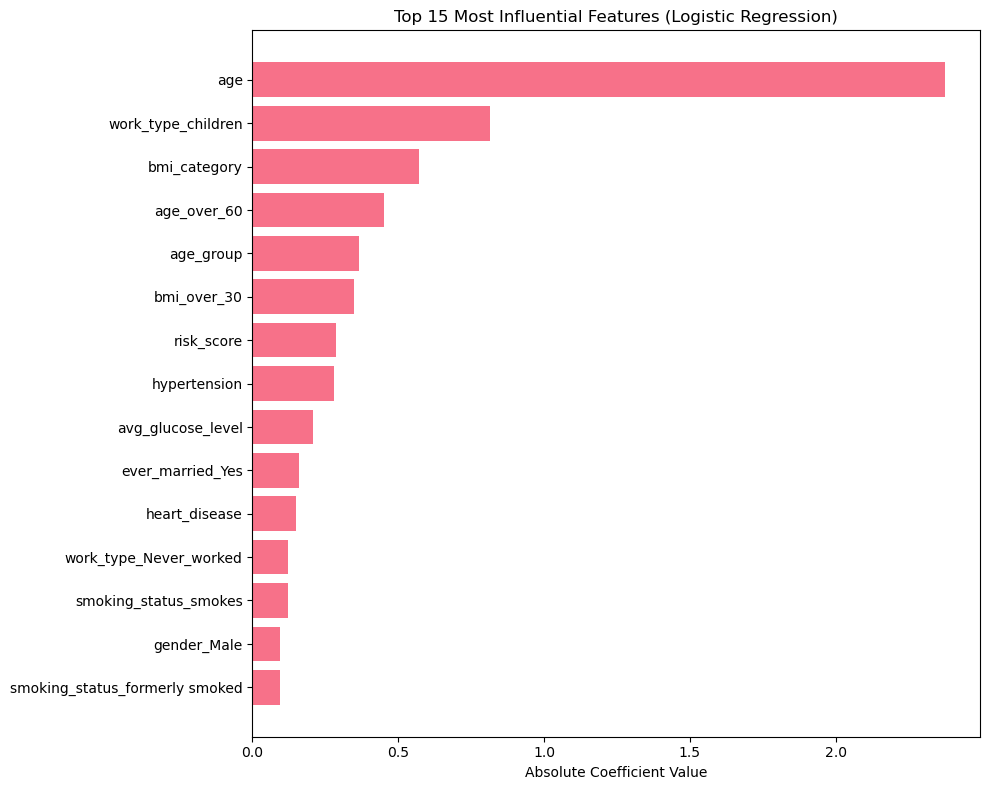

,Feature,Coefficient,Abs_Coefficient
0,age,2.375594,2.375594
11,work_type_children,0.813613,0.813613
17,bmi_category,0.569948,0.569948
18,age_over_60,-0.452217,0.452217
16,age_group,0.364726,0.364726
19,bmi_over_30,-0.346816,0.346816
20,risk_score,-0.286940,0.286940
1,hypertension,0.279384,0.279384
3,avg_glucose_level,0.206277,0.206277
7,ever_married_Yes,-0.160441,0.160441


In [23]:
print("Feature Importance - Logistic Regression")
print("="*60)

# Use final selected model (before tuning)
final_model = lr_fe

# Get coefficients
coefficients = final_model.coef_[0]
feature_names = X_train_fe.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values('Abs_Coefficient', ascending=False)

# Plot top 15 most influential features
plt.figure(figsize=(10, 8))
plt.barh(
    feature_importance_df['Feature'][:15],
    feature_importance_df['Abs_Coefficient'][:15]
)
plt.xlabel('Absolute Coefficient Value')
plt.title('Top 15 Most Influential Features (Logistic Regression)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

display(feature_importance_df.head(15))


### Feature Importance Interpretation

- Features with larger absolute coefficients have stronger influence on stroke prediction.
- Positive coefficients increase stroke probability.
- Negative coefficients decrease stroke probability.
- Age-related and cardiovascular risk features are expected to rank highest.
- This aligns with medical understanding of stroke risk factors.


# 8. Save Final Model

Save the model for deployment in Streamlit app

In [24]:
import pickle

print("Saving Final Model for Deployment")
print("="*60)

# Final selected model (feature engineered version before tuning)
final_model = lr_fe
final_scaler = scaler_fe
final_features = X_train_fe.columns.tolist()

# Save model
with open('stroke_prediction_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

# Save scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(final_scaler, f)

# Save feature names
with open('feature_names.pkl', 'wb') as f:
    pickle.dump(final_features, f)

print("Model and supporting files saved successfully")
print("Files created:")
print("- stroke_prediction_model.pkl")
print("- scaler.pkl")
print("- feature_names.pkl")


Saving Final Model for Deployment
Model and supporting files saved successfully
Files created:
- stroke_prediction_model.pkl
- scaler.pkl
- feature_names.pkl


# 9. Development Log

## Iteration 1: Baseline Models (Date: 02/11/2026)

- Trained 3 models: Random Forest, Gradient Boosting, Logistic Regression.
- Baseline (Dummy Classifier) achieved 95% accuracy but 0 recall.
- Random Forest and Gradient Boosting also resulted in 0 recall.
- Logistic Regression achieved recall = 0.80.
- Issue: Tree models failed to detect minority class.
- Decision: Select Logistic Regression as primary model due to highest recall.

---

## Iteration 2: Feature Engineering (Date: 02/11/2026)

- Added new features:
  - Age groups
  - BMI categories
  - Health risk score (hypertension + heart_disease + age_over_60 + bmi_over_30)
  - Glucose category
- Result:
  - Recall improved from 0.80 → 0.84 (+0.04).
  - ROC-AUC improved slightly.
- Analysis:
  - Age-based and cardiovascular risk features increased stroke detection.
- Decision:
  - Keep all engineered features.

---

## Iteration 3: Hyperparameter Tuning (Date: 02/11/2026)

- Used RandomizedSearchCV on Logistic Regression.
- Tuned parameters: C, solver.
- Best parameters: C=0.1, solver='liblinear'.
- Cross-validation recall ≈ 0.83.
- Test recall slightly decreased to 0.82.
- Decision:
  - Use feature engineered model before tuning (recall=0.84) as final model.

---

## Final Model Performance

- Model: Logistic Regression with feature engineering.
- Accuracy: 0.7456
- Recall: 0.84 (primary metric)
- F1-Score: 0.244
- ROC-AUC: 0.848

## Total Improvement from Baseline

- Baseline recall: 0.00
- Final recall: 0.84
- Improvement: +0.84 recall

The final model successfully detects 84% of stroke cases, significantly reducing false negatives compared to baseline approaches.
